In [43]:
import ujson as uj
import pandas as pd
import feather
import random
from utils import render_single, render_multiple, get_pixel_data, get_dataset_files, extract_random_entries, generate_pixel_columns
from IPython.display import display, Image as IPImage
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [606]:
files = get_dataset_files()
files = random.choices(files, k=1)
data = [extract_random_entries(file, 1000) for file in files]
flat_data = [item for sublist in data for item in sublist]
df = pd.DataFrame.from_dict(flat_data, orient='columns')
word = flat_data[0]['word']
print(f'Loaded {len(df)} entries from {files}')

Loaded 1000 entries from ['../dataset/calculator.ndjson']


In [ ]:
img = random.choice(flat_data)['drawing']
display(IPImage(render_single(img, magnification=4)))

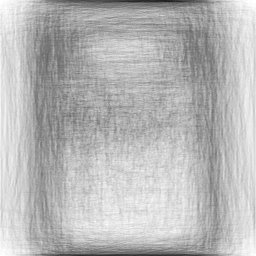

In [607]:
imgs = df.sample(1000)['drawing']
display(IPImage(render_multiple(imgs, magnification=1)))

In [569]:
df2 = generate_pixel_columns(df).drop(columns=['countrycode', 'timestamp', 'recognized', 'key_id', 'drawing'])

#df2.to_feather('../processed.dat')

In [3]:
#df3 = pd.read_feather('../processed.dat')
#print(df3)

#one hot encode words
word_columns = pd.get_dummies(df2['word'])
result = pd.concat([df2, word_columns], axis=1).drop(columns=['word'])
print(result)
result.to_feather('../processed.dat')

NameError: name 'df2' is not defined